In [1]:
import pandas as pd
import numpy as np

In [2]:
# 加载数据
from firefin.data.gateway import fetch_data
data = fetch_data(['market_cap', 'return_adj', 'pb_ratio','open','close','volume'])
rf = pd.read_feather(r'C:\Users\m1309\Downloads\bond_data\bond_data\us_bond_2y.feather')

2025-08-22 15:02:44.405 | INFO     | firefin.common.config:<module>:37 - No additional JSON files found in DATA_PATH, load default DATA_MAPS.
D:\PycharmProjects\fire_project\firefin\data\gateway.py:81: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(obj)
D:\PycharmProjects\fire_project\firefin\data\gateway.py:81: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(obj)


In [3]:
#把数据截取成想要的大小，并构造基本的指标如无风险利率，市净率等
mkt_cap = data['market_cap'].iloc[50:470, :100].dropna(axis = 1)

ret_adj = data['return_adj'].iloc[50:470, :100].dropna(axis = 1)

pb = data['pb_ratio'].iloc[50:470, :100].dropna(axis = 1)

open_price = data['open'].iloc[50:500, :100].dropna(axis = 1)

dates = mkt_cap.index
stock_code = mkt_cap.columns

bm = 1 / pb


#得到与 mkt_cap、ret_adj 索引一致的 risk_free_rate
if 'datetime' in rf.columns:
    rf['datetime'] = pd.to_datetime(rf['datetime'])
    rf = rf.set_index('datetime')
else:
    rf.index = pd.to_datetime(rf.index)
rf = rf['us_bond_2y']
rf.index = rf.index.normalize()
rf = rf.reindex(dates.normalize(), method='ffill') / 100
rf.index = dates
risk_free_rate = rf

#构造超额收益
excess_ret = ret_adj.sub(risk_free_rate, axis=0).fillna(0)

#构造动量信号
mom_signal = (data["close"] / data["close"].shift(21) -1).shift(1).iloc[50:470, :100]
mom_signal=mom_signal.drop(columns=["000166.SZ", "000333.SZ"])

In [4]:
#用当期收益率ret_adj构造新的（学术）因子，比如这里就是直接用pb进行打分然后构造多空组合(这里收益统一用字典，key是0表示当天的收益，value是T * quantiles的DataFrame)
return_adjusted = {}
return_adjusted[0]= ret_adj
from firefin.core.algorithm.portfolio_sort import PortfolioSort
pb_quantile_ret = PortfolioSort.single_sort(factor=pb, forward_returns=return_adjusted, quantiles=5, market_cap = mkt_cap)


In [5]:
#提取H-L这一项，将它作为后续检验的开始
pb_HML = [pb_quantile_ret[0].iloc[:,1]]

In [6]:
# 学术因子的检测，本项目里面有基础的AcaEvaluatorModel用来做学术因子对于收益率的检验
from firefin.evaluation.academia.AcaEvaluatorModel import *
basic_test = AcaEvaluatorModel(factor_portfolio=pb_HML,return_adj=excess_ret,time_series_window=None,cov_type="HAC")

In [7]:
#对该因子进行时序回归，返回因子暴露、截距、残差以及各种统计量
basic_test.run_time_series_regression()

BatchRegressionResult(
 alpha:
    stock_code           000001.SZ  000002.SZ  000004.SZ  000005.SZ  000006.SZ  \
    datetime                                                                     
    2009-03-23 15:00:00        NaN        NaN        NaN        NaN        NaN   
    2009-03-24 15:00:00        NaN        NaN        NaN        NaN        NaN   
    2009-03-25 15:00:00        NaN        NaN        NaN        NaN        NaN   
    2009-03-26 15:00:00        NaN        NaN        NaN        NaN        NaN   
    2009-03-27 15:00:00        NaN        NaN        NaN        NaN        NaN   
    ...                        ...        ...        ...        ...        ...   
    2010-12-03 15:00:00        NaN        NaN        NaN        NaN        NaN   
    2010-12-06 15:00:00        NaN        NaN        NaN        NaN        NaN   
    2010-12-07 15:00:00        NaN        NaN        NaN        NaN        NaN   
    2010-12-08 15:00:00        NaN        NaN        NaN        NaN

In [8]:
#进行横截面回归，返回因子暴露在横截面上的性质，返回回归系数，回归截距，残差以及t统计量
basic_test.run_cross_sectional_regression()

BatchRegressionResult(
 alpha:
    datetime
    2009-03-23 15:00:00         NaN
    2009-03-24 15:00:00         NaN
    2009-03-25 15:00:00         NaN
    2009-03-26 15:00:00         NaN
    2009-03-27 15:00:00         NaN
                             ...   
    2010-12-03 15:00:00         NaN
    2010-12-06 15:00:00         NaN
    2010-12-07 15:00:00         NaN
    2010-12-08 15:00:00         NaN
    2010-12-09 15:00:00   -0.005754
    Name: alpha, Length: 420, dtype: float64,
 alpha_t:
    datetime
    2009-03-23 15:00:00         NaN
    2009-03-24 15:00:00         NaN
    2009-03-25 15:00:00         NaN
    2009-03-26 15:00:00         NaN
    2009-03-27 15:00:00         NaN
                             ...   
    2010-12-03 15:00:00         NaN
    2010-12-06 15:00:00         NaN
    2010-12-07 15:00:00         NaN
    2010-12-08 15:00:00         NaN
    2010-12-09 15:00:00   -9.562917
    Name: alpha_t, Length: 420, dtype: float64,
 beta:
                                0
    da

In [9]:
#进行fama macbeth回归，得到横截面上的性质，返回回归系数，回归截距，t统计量
basic_test.run_fama_macbeth_regression()

In [10]:
from firefin.evaluation.academia.AcaIndirectEvaluator import *
pb_HML_indirect_test = AcaIndirectEvaluator(factor_portfolio=pb_HML, return_adj=ret_adj, risk_free_rate=risk_free_rate,
                         stock_size=mkt_cap, stock_value=bm, mom_signal=mom_signal)

<Axes: title={'center': 'grs p value'}, xlabel='time', ylabel='grs p value'>

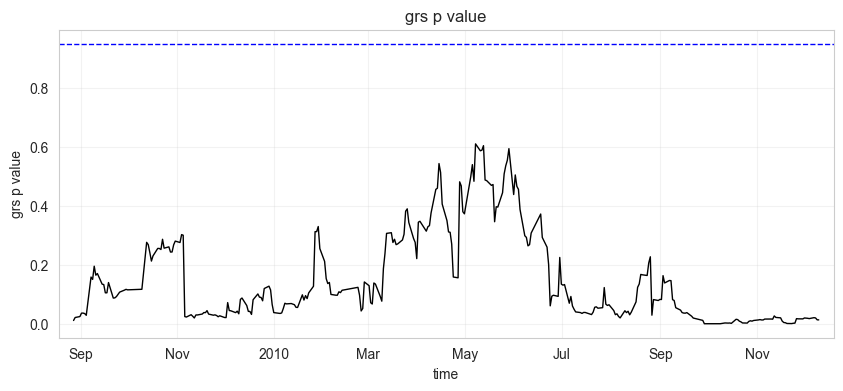

In [11]:
pb_HML_indirect_test.evaluate_stability(mode = "ff3_mom",window = 110)

In [12]:
# 对于pb这个指标我们可以对它的每一个分位数的性质都做检验，先构造分位收益率
quantile_ret = [pb_quantile_ret[0][col] for col in pb_quantile_ret[0].columns]

In [13]:
# 学术因子的检测，本项目里面有基础的AcaEvaluatorModel用来做学术因子对于收益率的检验
from firefin.evaluation.academia.AcaIndirectEvaluator import *

indirect_test = AcaIndirectEvaluator(factor_portfolio=quantile_ret, return_adj=ret_adj, risk_free_rate=risk_free_rate,
                         stock_size=mkt_cap, stock_value=bm, mom_signal=mom_signal)


In [14]:
# 构造对于每一个分位数检验的LaTex表格
indirect_test.export_evaluation_table()

D:\PycharmProjects\fire_project\firefin\evaluation\academia\AcaIndirectEvaluator.py:151: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  alpha_last = float(res.alpha.iloc[-1])
D:\PycharmProjects\fire_project\firefin\evaluation\academia\AcaIndirectEvaluator.py:156: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  alpha_t_last = float(res.alpha_t.iloc[-1])
D:\PycharmProjects\fire_project\firefin\evaluation\academia\AcaIndirectEvaluator.py:151: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  alpha_last = float(res.alpha.iloc[-1])
D:\PycharmProjects\fire_project\firefin\evaluation\academia\AcaIndirectEvaluator.py:156: FutureWarning: Calling float on a single element Series is deprecated and will raise a T

'\\toprule\n\\begin{tabular}{l c c c c c c c c c c c}\nPortfolio & \\multicolumn{2}{c}{Excess Return} & \\multicolumn{3}{c}{CAPM} & \\multicolumn{6}{c}{4-Factor} \\\\\n\\cmidrule(lr){2-3}\\cmidrule(lr){4-6}\\cmidrule(lr){7-12}\n & mean daily excess\\_ret & std & alpha & MKT & Adj \\$R\\textasciicircum{}2\\$ & alpha & MKT & SMB & HML & MOM & Adj \\$R\\textasciicircum{}2\\$ \\\\\n\\midrule\n1 & -0.008 & 0.020 & \\begin{tabular}[t]{@{}r@{}}0.01\\\\(15.15)\\end{tabular} & \\begin{tabular}[t]{@{}r@{}}0.94\\\\(40.21)\\end{tabular} & 0.794 & \\begin{tabular}[t]{@{}r@{}}0.01\\\\(18.19)\\end{tabular} & \\begin{tabular}[t]{@{}r@{}}0.91\\\\(42.14)\\end{tabular} & \\begin{tabular}[t]{@{}r@{}}0.27\\\\(6.39)\\end{tabular} & \\begin{tabular}[t]{@{}r@{}}0.23\\\\(6.72)\\end{tabular} & \\begin{tabular}[t]{@{}r@{}}-0.14\\\\(-4.94)\\end{tabular} & 0.854 \\\\\n2 & -0.008 & 0.020 & \\begin{tabular}[t]{@{}r@{}}0.01\\\\(16.37)\\end{tabular} & \\begin{tabular}[t]{@{}r@{}}0.97\\\\(42.11)\\end{tabular} & 0.809 &

In [15]:
indirect_test.evaluate_by_other_factors(mode = "capm")

D:\PycharmProjects\fire_project\firefin\evaluation\academia\AcaIndirectEvaluator.py:151: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  alpha_last = float(res.alpha.iloc[-1])
D:\PycharmProjects\fire_project\firefin\evaluation\academia\AcaIndirectEvaluator.py:156: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  alpha_t_last = float(res.alpha_t.iloc[-1])


(        alpha       MKT
 1    0.007082  0.944907
 2    0.007462  0.965323
 3    0.009172  1.004914
 4    0.010420  1.013731
 5    0.008710  0.832304
 H-L  0.001629 -0.112603,
          alpha        MKT
 1    15.150826  40.209226
 2    16.366894  42.114703
 3    23.239453  50.643657
 4    19.391861  37.525036
 5    14.493777  27.546402
 H-L   2.031361  -2.793442,
 1      0.794081
 2      0.808820
 3      0.859527
 4      0.770553
 5      0.643951
 H-L    0.015978
 Name: r2_adj, dtype: float64)

D:\PycharmProjects\fire_project\firefin\evaluation\academia\AcaIndirectEvaluator.py:297: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  alpha_i = float(res.alpha.iloc[-1])


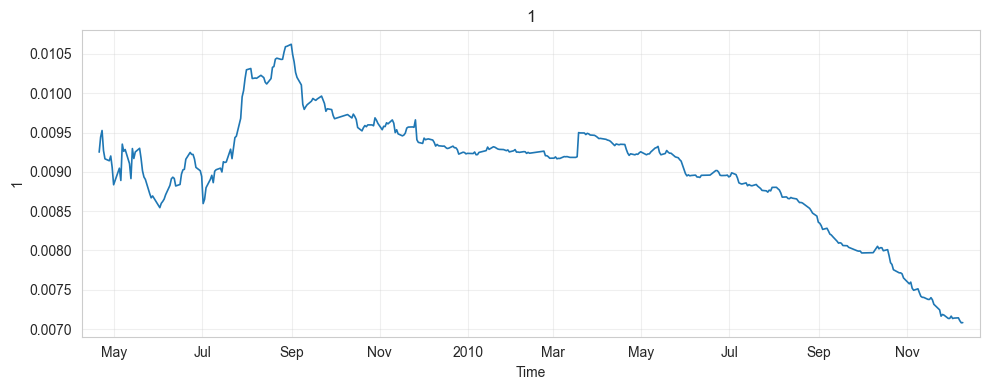

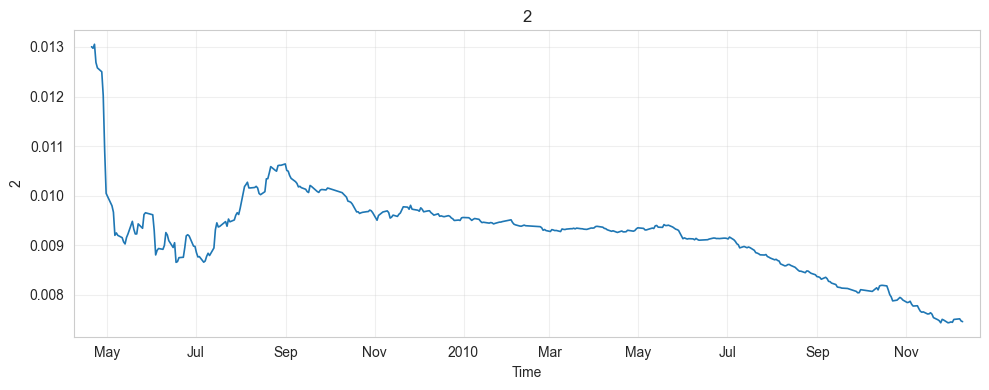

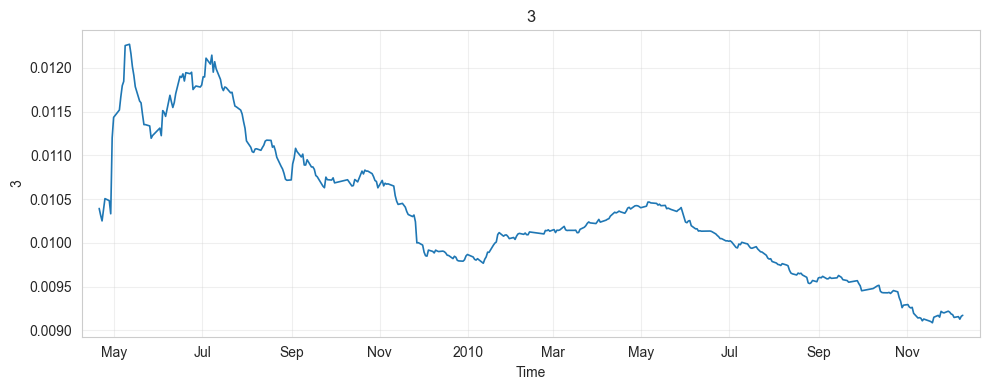

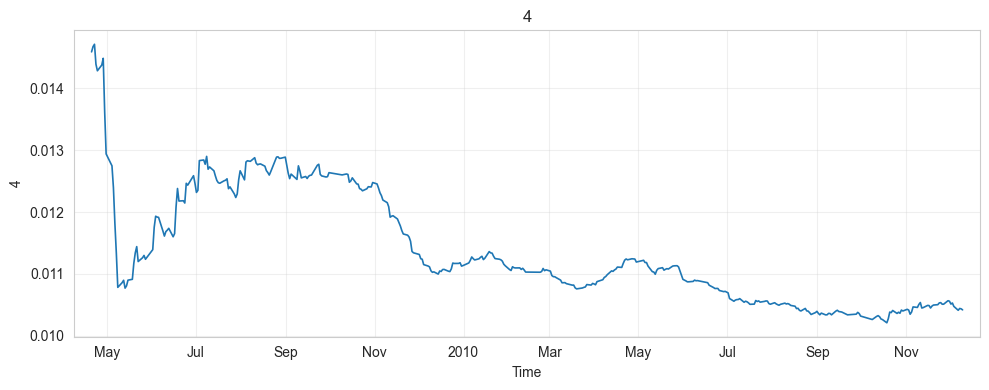

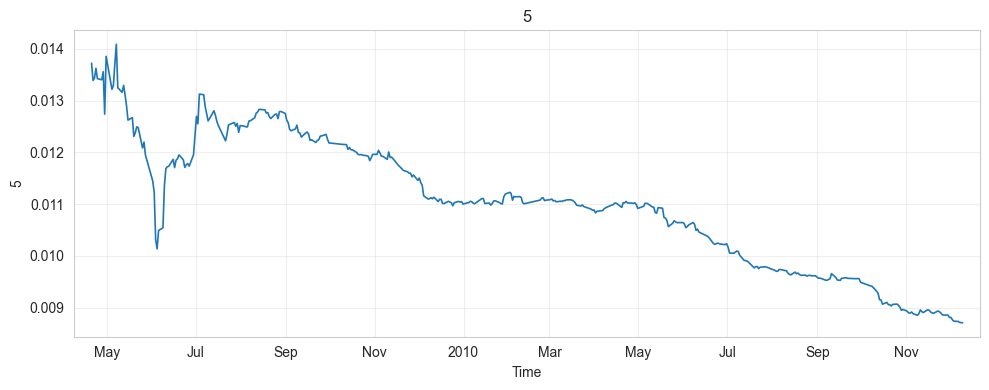

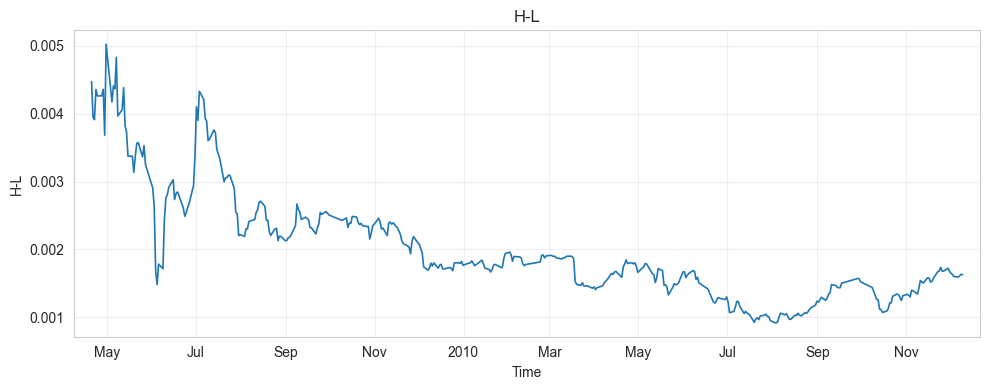

In [16]:
indirect_test.cumulated_alpha(mode = "capm")

In [17]:
# 项目提供了非常简便构造经典学术因子的函数，例如fama french 3因子
from firefin.evaluation.academia.AcademicFactors import *
ff3 = bundle_ff3(stock_return = ret_adj,
    size = mkt_cap,
    book_to_market = bm,
    market_cap = mkt_cap,
    risk_free_rate = risk_free_rate)

In [18]:
# 本项目提供了独立的做横截面回归的函数，可以输出回归系数以及检验指标，不需要走AcaEvaluator的流程了
from firefin.core.algorithm.cross_sectional_regression import *
res=cross_sectional_regression(ff3, excess_ret,cov_type="HAC",window=50)

In [19]:
# 本项目提供了单独的fama macbeth回归，返回回归系数的值以及其检验统计量，不需要走AcaEvaluator的流程了
from firefin.core.algorithm.fama_macbeth import *
rr=FamaMacBeth.run_regression(ff3, excess_ret,window=50)

In [20]:
#本项目提供一个封装好的RollingRegressor类，可以设定滚动窗口，得到时序axis=0,或截面axis=1的回归结果以及数据的检验统计量。
window = 120
ff3_factor = np.stack([f.values.reshape(-1, 1) for f in ff3], axis=0)
maxlag=int(4*(window/100)**(2/9))
from firefin.core.algorithm.regression import *
result = RollingRegressor(
    x = ff3_factor,
    y = excess_ret,
).fit(window=120,cov_type="HAC",cov_kwds={"maxlags": maxlag})


In [21]:
# newey west t 检验，检验回归系数是否显著为0
from firefin.core.algorithm.newey_west_t_statistics import NeweyWestTest
NeweyWestTest.newey_west_t_test(result, ff3)

{Timestamp('2009-09-10 15:00:00'):                alpha        MKT       SMB       HML
 stock_code                                         
 000001.SZ  -0.689307   4.416763 -1.620382  2.284227
 000002.SZ   0.522679  18.530719 -2.133647  0.362215
 000004.SZ   0.159704  12.617417  4.297489 -2.769045
 000005.SZ   0.463497  14.712610  2.681303  0.698536
 000006.SZ   0.238785  13.541036 -0.874637 -1.905503
 ...              ...        ...       ...       ...
 000423.SZ  -1.623572   8.168329  2.269899  1.320011
 000425.SZ  -0.034208  11.078600 -0.326325 -0.583695
 000426.SZ   2.216765   7.307621  5.182789 -0.477297
 000428.SZ  -0.284497  15.321203  4.704460 -1.134477
 000429.SZ  -2.670082  12.219356  2.835803  1.722523
 
 [98 rows x 4 columns],
 Timestamp('2009-09-11 15:00:00'):                alpha        MKT       SMB       HML
 stock_code                                         
 000001.SZ  -0.534661   4.509384 -1.533844  2.349692
 000002.SZ   0.419076  18.707516 -2.111349  0.342612
 0000